## 新聞文字分析  

目標  
* 從新聞資料中分析市場心理並找出和股價之相關性，由於希望和主題(科技類ETF)方向一致，選用科技新聞，而考慮到目標ETF(NDX/IXT/SPY/VGT/IYW)的成分股中，幾家龍頭科技公司佔有一定的權重，因此會過濾出與指定公司相關的新聞各自分析。

資料來源  
* 爬取Reuters網站上科技相關新聞(financial_news_crawling.ipynb)，總共22200筆資料，時間是2014-12-31至2019-05-02，以每段新聞的摘要為以下分析主要文本。

程式架構  
 
>* 文字處理/NLTK
>* 統計詞頻/Sklearn  
>* 視覺化統計結果  
>* TF-IDF/PCA  
>* 情緒分析
>* Cluster文字分群/K-means/PCA    

讀檔案，確認資料

In [126]:
import pandas as pd
df = pd.read_csv('financial_newsdata.csv') #read in data
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22200 entries, 0 to 22199
Data columns (total 5 columns):
Unnamed: 0    22200 non-null int64
link          22200 non-null object
title         22200 non-null object
summary       22200 non-null object
time          22200 non-null object
dtypes: int64(1), object(4)
memory usage: 867.3+ KB


,Unnamed: 0,link,title,summary,time
0,0,http://www.reuters.com/article/us-tesla-offeri...,"Tesla boosts capital raise to $2.7 billion, Mu...",Tesla Inc on Friday was set to raise up to $2....,10:52am EDT
1,1,http://www.reuters.com/article/us-uber-ipo-str...,Ride-hailing drivers in New York to strike ahe...,Uber Technologies Inc's drivers in New York wi...,8:33pm EDT
2,2,http://www.reuters.com/article/us-usa-trade-ch...,U.S. rejects Tesla bid for tariff exemption fo...,U.S. trade officials rejected Tesla Inc's bid ...,8:47pm EDT
3,3,http://www.reuters.com/article/us-telecoms-5g-...,"Western allies agree 5G security guidelines, w...",Global security officials agreed a set of prop...,2:33pm EDT
4,4,http://www.reuters.com/article/us-poland-tusk-...,EU's Tusk warns of risks in rise of U.S. tech ...,The world needs to be wary of the rise of tech...,12:07pm EDT


統計各則摘要字數，了解文本規模  

In [127]:
df['word_count'] = df['summary'].apply(lambda x: len(str(x).split(" ")))
df[['summary','word_count']].head()

,summary,word_count
0,Tesla Inc on Friday was set to raise up to $2....,41
1,Uber Technologies Inc's drivers in New York wi...,35
2,U.S. trade officials rejected Tesla Inc's bid ...,41
3,Global security officials agreed a set of prop...,28
4,The world needs to be wary of the rise of tech...,39


In [128]:
df.word_count.describe()

count    22200.000000
mean        33.720676
std          6.806294
min          5.000000
25%         30.000000
50%         34.000000
75%         38.000000
max         92.000000
Name: word_count, dtype: float64

列出文本中常用字以及不常用字  

In [129]:
com_word = pd.Series(' '.join(df['summary']).split()).value_counts()[:10] #Common words
uncom_word =  pd.Series(' '.join(df['summary']).split()).value_counts()[-10:] #Uncommon words
print(com_word,uncom_word)

the     28020
to      23511
a       19669
on      17820
of      16682
in      14878
and     12727
its     10087
said     8570
for      7488
dtype: int64 ($14.60             1
rig.                1
Owners              1
masts               1
old-style           1
Minhaj"             1
ever-expanding      1
crypto-currency,    1
up".                1
human-rights        1
dtype: int64


原始資料不理想，常用字幾乎都是廢詞，以下進一步作文字清理  

### NLTK  
text clean-up

In [130]:
import re
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
#nltk.download('wordnet') 
from nltk.stem.wordnet import WordNetLemmatizer

nltk套件中其實已經有停用字的word list，但後面檢查結果後還是有些多餘字並非想關注的重點，或是有廢字沒有被成功清理掉，因此擴充原本的停用字庫  

In [131]:
##get stop words and add other stopwords
stop_words = set(stopwords.words("english"))

##other stop words
add_words = ['said', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'one', 'two','three','four',
             'shown', 'co','u', 'ltd','york','would','year','inc','com','corp']
stop_words = stop_words.union(add_words)

In [132]:
corpus = []
for i in range(0, 22200):
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', df['summary'][i])
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    
    ##Stemming
    ps=PorterStemmer()
    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in stop_words] 
    text = " ".join(text)
    corpus.append(text)

corpusk = corpus #for k-means cluster
print(corpus[0:10])

['tesla set raise billion record setting capital raising electric carmaker investor scooped mix new stock convertible note recharge company cash depleted balance sheet', 'uber technology driver new go strike next week shortly ride hailing company go public protest view unfair employment condition taxi union', 'trade official rejected tesla bid relief president donald trump percent tariff chinese made autopilot brain model electric vehicle product denial linked china industrial development plan', 'global security official agreed set proposal future g network highlighting concern equipment supplied vendor might subject state influence', 'world need wary rise tech giant google apple facebook amazon comparing power country china european council president donald tusk warsaw', 'european union began push improved protection trader consumer involved online transaction published proposal launching likely long hard wto negotiation regulating e commerce', 'bitcoin jumped new six month high move 

### Sklearn  

用CountVectorizer將文本中的詞語轉換成詞頻矩陣，統計常出現的詞  

In [61]:
from sklearn.feature_extraction.text import CountVectorizer
import re
cv=CountVectorizer(max_df=0.9,stop_words=stop_words, max_features=15000, ngram_range=(1,3))
X=cv.fit_transform(corpus)

In [62]:
#check the key words
print(len(list(cv.vocabulary_.keys())))
print(list(cv.vocabulary_.keys())[10:20])
#X.toarray

15000
['investor', 'mix', 'new', 'stock', 'convertible', 'note', 'company', 'cash', 'balance', 'sheet']


找出TOP 20最常用的單字，詞，以及三字詞組

In [63]:
#get the most frequently occuring words
def get_top_words(corpus, n=None, i=None):
    
    if i == 1:  #words
        vec = CountVectorizer().fit(corpus)      
    elif i == 2:  #Bi-grams  
        vec = CountVectorizer(ngram_range=(2,2),max_features=2000).fit(corpus)      
    elif i ==3:  #Tri-grams
        vec = CountVectorizer(ngram_range=(3,3),max_features=2000).fit(corpus)
        
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_words(corpus, n=200, i=1)

top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq1"]

top2_words = get_top_words(corpus, n=200, i=2)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq2"]

top3_words = get_top_words(corpus, n=200, i=3)
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq3"]
topwords = pd.concat([top_df,top2_df,top3_df], axis=1)
print(topwords[:20])

          Word  Freq1              Bi-gram  Freq2  \
0      company   5846      chief executive   1246   
1   technology   3359         united state    782   
2          new   2907      familiar matter    660   
3      service   2583         ride hailing    606   
4      billion   2559         self driving    537   
5      million   2410  samsung electronics    514   
6         firm   2184      uber technology    511   
7     business   2059         told reuters    504   
8        group   2000        social medium    472   
9    executive   1927      people familiar    462   
10       china   1905          wall street    434   
11       chief   1760         cyber attack    395   
12       apple   1747              uber ul    377   
13       maker   1724       european union    368   
14      market   1723      reported citing    344   
15        data   1559   technology company    336   
16        uber   1524         electric car    333   
17       state   1520          driving car    

視覺化，將常用字輸出成文字雲展示  

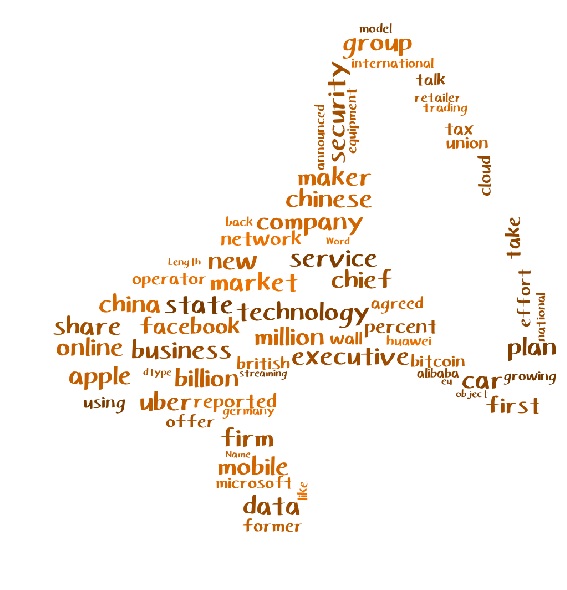

In [64]:
#Word cloud
import os
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

#from scipy.misc import imread
#M = imread('speaker1.png')
import imageio
M = imageio.imread('speaker2.png')
fontpath='HanyiSentyChalk.ttf'

#set the color
def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 21.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud = WordCloud(font_path=fontpath,background_color='white', stopwords=stop_words, max_words=3000,
                        max_font_size=50, min_font_size=2,random_state=42,mask=M,
                        color_func=random_color_func
                         ).generate(str(top_df['Word']))

print(wordcloud)
plt.figure(figsize=(15,10))
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

看起來很符合科技新聞的主題，也幾乎沒有廢詞了，仔細看了一下，China應該是因為市場大，是常被報導的國家，若以公司來看，科技龍頭Apple、Microsoft受到的關注不小，被提及的還有Uber、Alibaba等，主題則有快速興起的Bitcoin，以及近幾年來熱門研發項目Car(從上面的三字詞組來看應為自駕車)  

接著，針對特定公司 - Facebook、Apple、Microsoft、Alphabet、Amazon，過濾出有提到其公司名稱的新聞，並列出這些新聞中的常用字以分析公司特性，觀察之間有沒有共通點  

In [65]:
import matplotlib.pyplot as plt
#set plot type
#plt.rcParams['figure.figsize'] = (18, 2)
font = {'family': 'Segoe Print', 'weight': 'normal', 'size': 19}
plt.rc('font',**font)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=12)

In [66]:
#related news
fb = [] 
apple = []
micro = []
alph = []
amazon = []

for w in corpus:
    if 'facebook' in w:
        fb.append(w)
    if 'apple' in w:
        apple.append(w)
    if 'microsoft' in w:
        micro.append(w)
    if 'alphabet' in w:
        alph.append(w)
    if 'amazon' in w:
        amazon.append(w)

print('Facebook:'+str(len(fb)),' Apple:'+str(len(apple)),' Microsoft:'+str(len(micro)),
      ' Alphabet:'+str(len(alph)),' Amazon:'+str(len(amazon)))
#company_news = pd.DataFrame({'Facebook':fb,'Apple':apple,'Microsoft':micro,'Alphabet':alph,'Amazon':amazon})  

Facebook:1310  Apple:1581  Microsoft:403  Alphabet:587  Amazon:884


以上是各公司在2015-2019年被提及的新聞篇數，Apple有1581篇居首位，Facebook也有1310篇，不過以總數22200來說皆算少，是因為這裡只採用新聞摘要的關係，為求謹慎之後可以再考慮整篇新聞文本，由於摘要的定義應為整篇新聞重點，以現有資料分析得到的結果應仍有參考價值。

計算詞頻  

In [67]:
#Facebook
fb_top_words = get_top_words(fb, n=300, i=1)
fb_top_df = pd.DataFrame(fb_top_words)
fb_top_df.columns=["Word", "Freq1"]
#Apple
ap_top_words = get_top_words(apple, n=300, i=1)
ap_top_df = pd.DataFrame(ap_top_words)
ap_top_df.columns=["Word", "Freq1"]
#Microsoft
mi_top_words = get_top_words(micro, n=300, i=1)
mi_top_df = pd.DataFrame(mi_top_words)
mi_top_df.columns=["Word", "Freq1"]
#Alphabet
al_top_words = get_top_words(alph, n=300, i=1)
al_top_df = pd.DataFrame(al_top_words)
al_top_df.columns=["Word", "Freq1"]
#Amazon
am_top_words = get_top_words(amazon, n=300, i=1)
am_top_df = pd.DataFrame(am_top_words)
am_top_df.columns=["Word", "Freq1"]

視覺化，列出各公司TOP 20常用字  

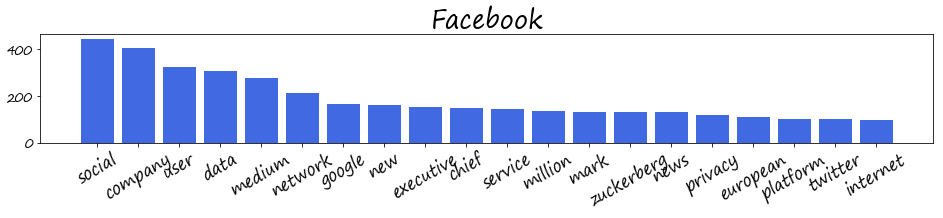

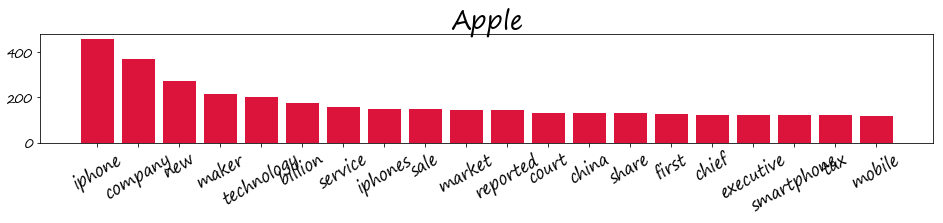

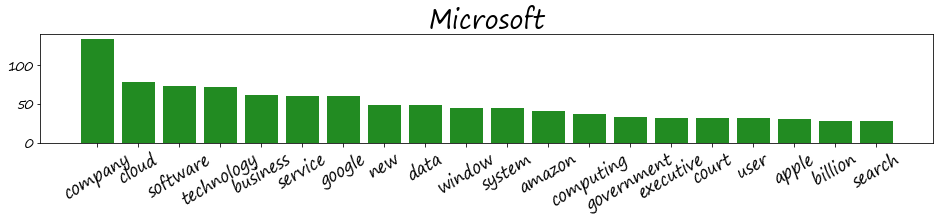

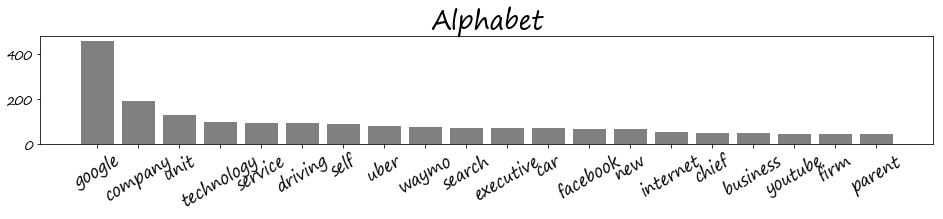

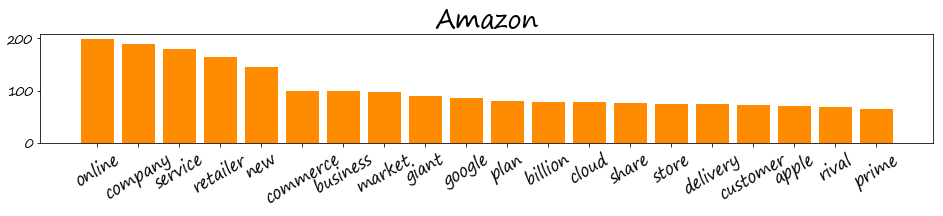

In [68]:
def plot(company,x,y,color):
    plt.figure(figsize=(16,2))
    plt.title(company,fontsize=25)
    plt.xticks(rotation=30)
    plt.bar(x,y,color=color)

plot('Facebook',fb_top_df['Word'][1:21],fb_top_df['Freq1'][1:21],'royalblue')
plot('Apple',ap_top_df['Word'][1:21],ap_top_df['Freq1'][1:21],'crimson')
plot('Microsoft',mi_top_df['Word'][1:21],mi_top_df['Freq1'][1:21],'forestgreen')
plot('Alphabet',al_top_df['Word'][1:21],al_top_df['Freq1'][1:21],'gray')
plot('Amazon',am_top_df['Word'][1:21],am_top_df['Freq1'][1:21],'darkorange')
plt.show()

常用字重點:
> FB - 
身為social media，前1-4名都可以理解，而上任新執行長Zuckerberg在FB"出事"時顯然都責無旁貸，另外常一起出現的還有競爭對手Google、Twitter等，European是目前比較想不通的，可能和歐洲市場有關  

> Apple - 
比較常提及的都是其新產品，顯然其每次推產品上市都會引起關注，值得注意的是China列為常用字，應和中國代工有關，其他關心議題還有tax、share等，可見貿易中公司對稅率的關心程度  

> Microsoft - 
一樣出現對手公司Google、Amazon、Apple等，提及的多為產品相關，如system、service、search等  

> Alphabet - 
身為Google控股母公司，2015年Google則成為其下屬全資子公司(基本上是同一家(?))，也難怪共現性強，競爭公司有Facebook、Youtube、等，Uber會出現和其對自駕車投入有關，如同這裡出現的self、driving等字，Waymo即是為Alphabet旗下的子公司，專門研發自動駕駛汽車，原本Alphabet是Uber的金主，2017年時卻改投資其對手公司Lyft  

> Amazon - 
一起出現的公司有Google、Apple，業務相關有online、cloud、delivery等，值得關注是常用字中有giant一字，推測出現的多為正面描述  

共同點 : new、company、share、market等，和科技業產品生命週期短，新聞性質偏財經有關  

以下先作PCA的文字預處理  

In [69]:
#company_news
fb = pd.DataFrame({'company':'Facebook','news':fb[:100]})
apple = pd.DataFrame({'company':'Apple','news':apple[:100]})
micro = pd.DataFrame({'company':'Microsoft','news':micro[:100]})
alph = pd.DataFrame({'company':'Alphabet','news':alph[:100]})
amazon = pd.DataFrame({'company':'Amazon','news':amazon[:100]})
com_news = pd.concat([fb,apple,micro,alph,amazon])
com_news.head()

,company,news
0,Facebook,world need wary rise tech giant google apple f...
1,Facebook,facebook potential settlement regulator breach...
2,Facebook,facebook federal trade commission ftc negotiat...
3,Facebook,facebook debuted overhaul core social network ...
4,Facebook,facebook unveiled redesigned app rolled dating...


同一間公司的相關新聞合併成一份  

In [70]:
com_corpus = com_news.groupby(['company'])['news'].apply(' '.join).reset_index()
com_corpus.head()

,company,news
0,Alphabet,alphabet youtube unveiled nine new original pr...
1,Amazon,world need wary rise tech giant google apple f...
2,Apple,world need wary rise tech giant google apple f...
3,Facebook,world need wary rise tech giant google apple f...
4,Microsoft,microsoft announced new tool software maker ai...


### TF-IDF  

In [71]:
corpus = com_corpus['news'].values.tolist()

In [72]:
# coding:utf-8  
from sklearn.feature_extraction.text import CountVectorizer  
vectorizer = CountVectorizer()  
X = vectorizer.fit_transform(corpus)  
word = vectorizer.get_feature_names()  

from sklearn.feature_extraction.text import TfidfTransformer  
transformer = TfidfTransformer()  
tfidf = transformer.fit_transform(X)

In [73]:
features = tfidf.toarray()
labels = com_corpus['company'].values
labels

array(['Alphabet', 'Amazon', 'Apple', 'Facebook', 'Microsoft'],
      dtype=object)

### PCA  

降維，用一組(X,Y)表示一間公司的相關新聞  

In [74]:
# PCA
from sklearn.decomposition import PCA
pca = PCA()#n_components=5
transData = pca.fit_transform(features, labels)
type(transData)
com_corpus['pca1'] = pd.DataFrame(transData[:,0])
com_corpus['pca2'] = pd.DataFrame(transData[:,1])
com_corpus.head()

,company,news,pca1,pca2
0,Alphabet,alphabet youtube unveiled nine new original pr...,0.452996,0.082159
1,Amazon,world need wary rise tech giant google apple f...,-0.190605,-0.469259
2,Apple,world need wary rise tech giant google apple f...,-0.451022,0.660131
3,Facebook,world need wary rise tech giant google apple f...,0.552437,0.078301
4,Microsoft,microsoft announced new tool software maker ai...,-0.363806,-0.351333


視覺化，觀察各公司相關新聞的連動性強不強，有無相似性質  

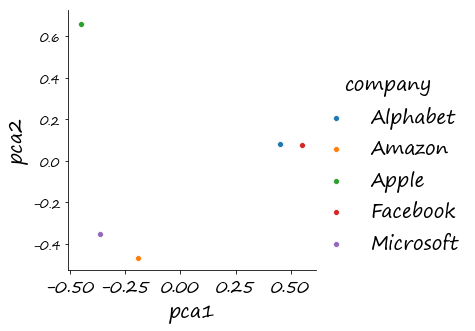

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(x_vars=['pca1'], y_vars=['pca2'], data=com_corpus, hue="company", height=5)

可以看到如果要分的話會有三群，分別是Apple、Alphabet和Facebook、以及Amazon和Microsoft，沒有想像中集中  

### Sentiment analysis  

接下來處理極具應用價值的字詞情緒分析，這裡直接使用NLTK中的套件SentimentIntensityAnalyzer計算情緒分數  

為了避免Garbage in, garbage out的情況，先檢查此系統符不符合資料，建函數觀察系統分類字詞情況以及分數範圍  

In [76]:
#import nltk
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, RegexpTokenizer

Analyzer = SentimentIntensityAnalyzer()

#clear version(print out positive & negative words, also all the scores)
def sentiment_result(news):

    sentence = news
    tokenized_sentence = nltk.word_tokenize(sentence)
    pos_word_list=[]
    neu_word_list=[]
    neg_word_list=[]

    for word in tokenized_sentence:
        if (Analyzer.polarity_scores(word)['compound']) >= 0.1:
            pos_word_list.append(word)
        elif (Analyzer.polarity_scores(word)['compound']) <= -0.1:
            neg_word_list.append(word)
        else:
            neu_word_list.append(word)                

    print('\nPositive:',pos_word_list)
    print('Neutral:',neu_word_list)
    print('Negative:',neg_word_list) 
    score = Analyzer.polarity_scores(sentence)
    print('\nScores:', score)

#observ the scores to decide whether edit the word list
for i in fb['news'][:10]:
    sentiment_result(i)



Positive: ['amazon']
Neutral: ['world', 'need', 'wary', 'rise', 'tech', 'giant', 'google', 'apple', 'facebook', 'comparing', 'power', 'country', 'china', 'european', 'council', 'president', 'donald', 'tusk', 'warsaw']
Negative: []

Scores: {'neg': 0.053, 'neu': 0.865, 'pos': 0.082, 'compound': 0.1531}

Positive: ['agreement']
Neutral: ['facebook', 'potential', 'settlement', 'regulator', 'breach', 'consumer', 'data', 'privacy', 'nearing', 'completion', 'likely', 'include', 'whatsapp', 'messaging', 'service', 'wall', 'street', 'journal', 'reported', 'citing', 'people', 'familiar', 'matter']
Negative: []

Scores: {'neg': 0.0, 'neu': 0.837, 'pos': 0.163, 'compound': 0.5106}

Positive: ['create', 'safeguard']
Neutral: ['facebook', 'federal', 'trade', 'commission', 'ftc', 'negotiating', 'possible', 'settlement', 'require', 'company', 'independent', 'privacy', 'oversight', 'committee', 'take', 'step', 'user', 'politico', 'reported', 'citing', 'source']
Negative: []

Scores: {'neg': 0.0, 'neu

挑出來的正面以及負面字都合理，不過似乎漏掉了一些我認為也是常用之正(負)面字，因此修改其word list  

In [77]:
#edit the words
new_words = {'wary': -2.0, 'giant': 1.0, 'new':0.1, 
             'amazon':0.0, 'facebook':0.0, 'alphabet':0.0, 'microsoft':0.0,'apple':0.0}
Analyzer.lexicon.update(new_words)

建立一個只給分數的函數，找一篇FB相關文章再測試一次  

In [80]:
#simple version, only get score
def sentiment_value(news):
    result = Analyzer.polarity_scores(news)
    score = result['compound']
    return (score)#round(score,1)

test = sentiment_value(fb['news'][0])
print(fb['news'][0],test)

world need wary rise tech giant google apple facebook amazon comparing power country china european council president donald tusk warsaw -0.2732


由於科技財經新聞可能包含許多專業術語，怕評分機制不完善，引入相關word list擴充  

* LoughranMcDonald_SentimentWordLists - an Excel file containing each of the LM sentiment words, based on finance and accounting research, contains financial terminology.

讀檔案，觀察資料  

In [81]:
#read in LoughranMcDonald_SentimentWordLists
mcword_list = pd.read_excel('LoughranMcDonald_SentimentWordLists_2018.xlsx', sheet_name='Negative')
mcword_list.columns.values[0]='Negative'
mcword_list['Negative'] = mcword_list['Negative'].str.lower()
mcword_list['Positive'] = pd.read_excel('LoughranMcDonald_SentimentWordLists_2018.xlsx', sheet_name='Positive')
mcword_list['Positive'] = mcword_list['Positive'].str.lower()
mcword_list['Uncertainty'] = pd.read_excel('LoughranMcDonald_SentimentWordLists_2018.xlsx', sheet_name='Uncertainty')
mcword_list['Uncertainty'] = mcword_list['Uncertainty'].str.lower()
mcword_list['Litigious'] = pd.read_excel('LoughranMcDonald_SentimentWordLists_2018.xlsx', sheet_name='Litigious')
mcword_list['Litigious'] = mcword_list['Litigious'].str.lower()
mcword_list['Strong'] = pd.read_excel('LoughranMcDonald_SentimentWordLists_2018.xlsx', sheet_name='StrongModal')
mcword_list['Strong'] = mcword_list['Strong'].str.lower()
mcword_list['Weak'] = pd.read_excel('LoughranMcDonald_SentimentWordLists_2018.xlsx', sheet_name='WeakModal')
mcword_list['Weak'] = mcword_list['Weak'].str.lower()
mcword_list['Constrain'] = pd.read_excel('LoughranMcDonald_SentimentWordLists_2018.xlsx', sheet_name='Constraining')
mcword_list['Constrain'] = mcword_list['Constrain'].str.lower()
#print(mcword_list)
mcword_list.head()

,Negative,Positive,Uncertainty,Litigious,Strong,Weak,Constrain
0,abandoned,abundance,abeyances,abrogate,best,apparently,abiding
1,abandoning,abundant,almost,abrogated,clearly,appeared,bound
2,abandonment,acclaimed,alteration,abrogates,definitely,appearing,bounded
3,abandonments,accomplish,alterations,abrogating,definitively,appears,commit
4,abandons,accomplished,ambiguities,abrogation,highest,conceivable,commitment


捨棄和法律相關的部分以及字詞總量少的後面三個欄位，只採用正面和負面字加進現有評分機制  

觀察新word list中的字原本的機制下有沒有被考慮到，如果沒有，正面統一給3分，負面給-3分，丟進word list  

In [82]:
#check if the current analyzer already considered the negative mcwords
#k = 0
for i in mcword_list['Negative']:
    test = sentiment_value(i)
    '''
    if test == 0.0:
        k += 1
    print(i,test)''' 
    #the result shows that there are 1672 words identified neutral yet is actually negative, so I must do something to fix it
    if test == 0.0:
        new_words[i] = -3.0
print(new_words)

{'wary': -2.0, 'giant': 1.0, 'new': 0.1, 'amazon': 0.0, 'facebook': 0.0, 'alphabet': 0.0, 'microsoft': 0.0, 'apple': 0.0, 'abdicated': -3.0, 'abdicates': -3.0, 'abdicating': -3.0, 'abdication': -3.0, 'abdications': -3.0, 'aberrant': -3.0, 'aberration': -3.0, 'aberrational': -3.0, 'aberrations': -3.0, 'abetting': -3.0, 'abnormal': -3.0, 'abnormalities': -3.0, 'abnormality': -3.0, 'abnormally': -3.0, 'abolish': -3.0, 'abolished': -3.0, 'abolishes': -3.0, 'abolishing': -3.0, 'abrogate': -3.0, 'abrogated': -3.0, 'abrogates': -3.0, 'abrogating': -3.0, 'abrogation': -3.0, 'abrogations': -3.0, 'abrupt': -3.0, 'abruptly': -3.0, 'abruptness': -3.0, 'absence': -3.0, 'absences': -3.0, 'absenteeism': -3.0, 'acquiesce': -3.0, 'acquiesced': -3.0, 'acquiesces': -3.0, 'acquiescing': -3.0, 'acquittal': -3.0, 'acquittals': -3.0, 'adulterate': -3.0, 'adulterated': -3.0, 'adulterating': -3.0, 'adulteration': -3.0, 'adulterations': -3.0, 'aftermath': -3.0, 'aftermaths': -3.0, 'against': -3.0, 'aggravation'

In [83]:
#similarly, deal with positive words(there are 166/353 words not considered)
for i in mcword_list['Positive'][:353]:
    test = sentiment_value(i)
    if test == 0.0:
        new_words[i] = 3.0

重複上面的過程，再給新聞打一次分數  

In [84]:
#edit the Analyzer word list and check the score again
Analyzer.lexicon.update(new_words)

for i in fb['news'][:3]:
    sentiment_result(i)  


Positive: ['giant']
Neutral: ['world', 'need', 'rise', 'tech', 'google', 'apple', 'facebook', 'amazon', 'comparing', 'power', 'country', 'china', 'european', 'council', 'president', 'donald', 'tusk', 'warsaw']
Negative: ['wary']

Scores: {'neg': 0.177, 'neu': 0.736, 'pos': 0.087, 'compound': -0.2732}

Positive: ['agreement']
Neutral: ['facebook', 'potential', 'settlement', 'regulator', 'consumer', 'data', 'privacy', 'nearing', 'completion', 'likely', 'include', 'whatsapp', 'messaging', 'service', 'wall', 'street', 'journal', 'reported', 'citing', 'people', 'familiar', 'matter']
Negative: ['breach']

Scores: {'neg': 0.137, 'neu': 0.717, 'pos': 0.147, 'compound': -0.1779}

Positive: ['create', 'safeguard']
Neutral: ['facebook', 'federal', 'trade', 'commission', 'ftc', 'negotiating', 'possible', 'settlement', 'require', 'company', 'independent', 'privacy', 'oversight', 'committee', 'take', 'step', 'user', 'politico', 'reported', 'citing', 'source']
Negative: []

Scores: {'neg': 0.0, 'neu

修正後結果和前面不同，正面和負面字也有被較精確地抓出來

計算各公司每條新聞摘要之分數  

In [85]:
#Facebook
fb_score = []
for i in fb['news']:
    fb_score.append(sentiment_value(i))
#print(fb_score)
fb['score'] = pd.DataFrame(fb_score)

#Apple
apple_score = []
for i in apple['news']:
    apple_score.append(sentiment_value(i))
apple['score'] = pd.DataFrame(apple_score)

#Microsoft
micro_score = []
for i in micro['news']:
    micro_score.append(sentiment_value(i))
micro['score'] = pd.DataFrame(micro_score)

#Alphabet
alph_score = []
for i in alph['news']:
    alph_score.append(sentiment_value(i))
alph['score'] = pd.DataFrame(alph_score)

#Amazon
amazon_score = []
for i in amazon['news']:
    amazon_score.append(sentiment_value(i))
amazon['score'] = pd.DataFrame(amazon_score)

#check the scores
print(fb.head(),apple.head(),micro.head(),alph.head(),amazon.head())

    company                                               news   score
0  Facebook  world need wary rise tech giant google apple f... -0.2732
1  Facebook  facebook potential settlement regulator breach... -0.1779
2  Facebook  facebook federal trade commission ftc negotiat...  0.5719
3  Facebook  facebook debuted overhaul core social network ... -0.4215
4  Facebook  facebook unveiled redesigned app rolled dating...  0.6908   company                                               news   score
0   Apple  world need wary rise tech giant google apple f... -0.2732
1   Apple  qualcomm share fell investor got first look bo... -0.1027
2   Apple  apple share rose nearly percent pushing iphone... -0.0258
3   Apple  apple sale china stabilizing touted increasing...  0.2960
4   Apple  far netflix killer apple envisions forthcoming... -0.6486      company                                               news   score
0  Microsoft  microsoft announced new tool software maker ai...  0.7184
1  Microsoft  mi

以不分類文本計算分數(代表整個市場情況)  

In [86]:
mkt = pd.DataFrame({'news':df['summary'][:100]})

mkt_score = []
for i in mkt['news']:
    mkt_score.append(sentiment_value(i))
mkt['score'] = pd.DataFrame(mkt_score)
mkt.head()   

,news,score
0,Tesla Inc on Friday was set to raise up to $2....,0.0258
1,Uber Technologies Inc's drivers in New York wi...,-0.6705
2,U.S. trade officials rejected Tesla Inc's bid ...,-0.6369
3,Global security officials agreed a set of prop...,-0.1280
4,The world needs to be wary of the rise of tech...,-0.4767


畫出正、負面新聞分布數量，藉此推測市場景況  

<BarContainer object of 100 artists>

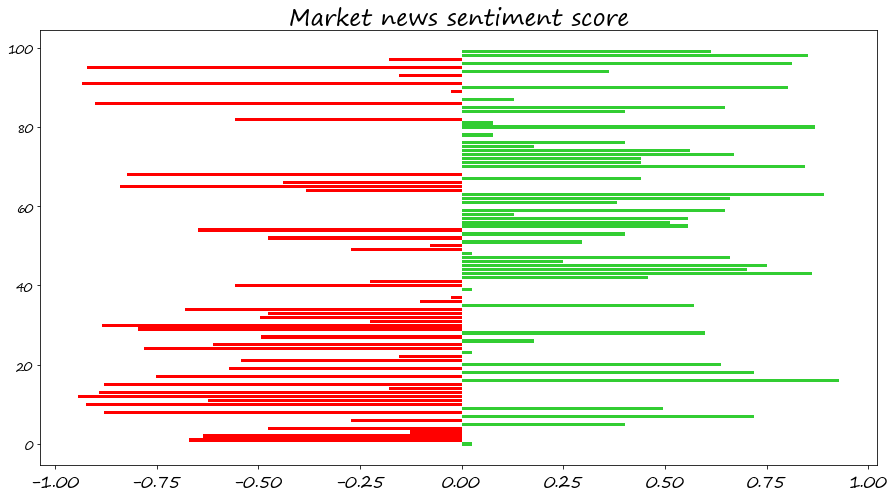

In [87]:
mkt['positive'] = mkt['score'] > 0 
plt.figure(figsize=(15,8))
plt.title('Market news sentiment score')
plt.barh(range(len(mkt['score'])), mkt['score'],color=mkt.positive.map({True: 'limegreen', False: 'red'}))

資料前半部分以負面新聞為主，後面則較多正向內容，整體來說正負各半  

發現資料量蠻大的，接下來各公司的分數圖只採用最近的新聞分析(前20筆)，畫出五家公司以及市場的新聞情緒情況  

In [88]:
#creat dummy column(to set different color of negative & positive data)
fb['positive'] = fb['score'] > 0 
apple['positive'] = apple['score'] > 0
micro['positive'] = micro['score'] > 0
alph['positive'] = alph['score'] > 0
amazon['positive'] = amazon['score'] > 0

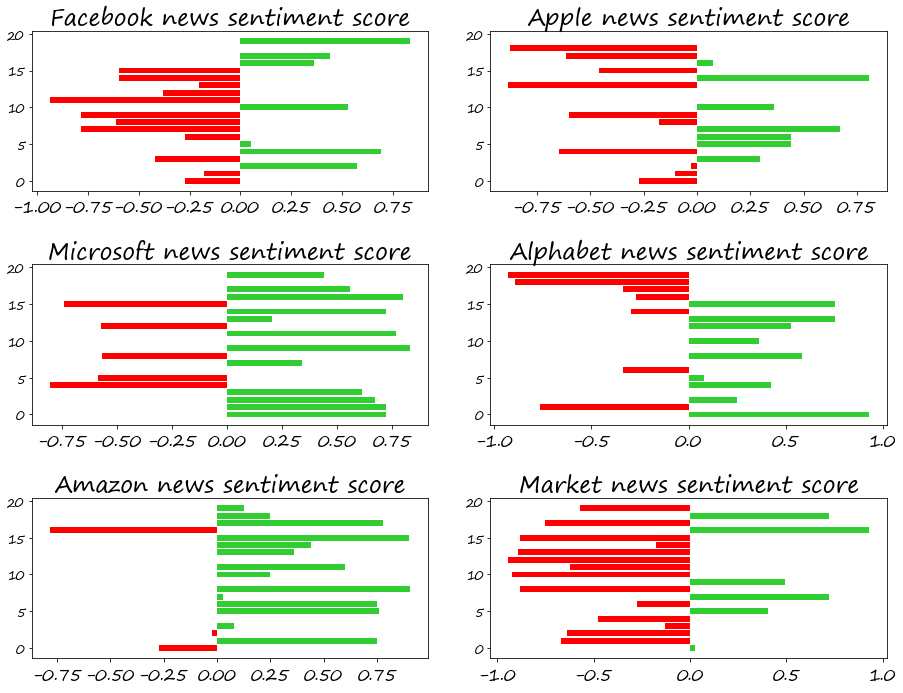

In [89]:
plt.figure(figsize=(13,10))
plt.subplot(3,2,1) #2行2列 目前在1
plt.title('Facebook news sentiment score')
plt.barh(range(len(fb['score'][:20])),fb['score'][:20],color=fb.positive.map({True: 'limegreen', False: 'red'}))

plt.subplot(3,2,2)
plt.title('Apple news sentiment score')
plt.barh(range(len(apple['score'][:20])),apple['score'][:20],color=apple.positive.map({True: 'limegreen', False: 'red'}))

plt.subplot(3,2,3)
plt.title('Microsoft news sentiment score')
plt.barh(range(len(micro['score'][:20])),micro['score'][:20],color=micro.positive.map({True: 'limegreen', False: 'red'}))

plt.subplot(3,2,4)
plt.title('Alphabet news sentiment score')
plt.barh(range(len(alph['score'][:20])),alph['score'][:20],color=alph.positive.map({True: 'limegreen', False: 'red'}))

plt.subplot(3,2,5)
plt.title('Amazon news sentiment score')
plt.barh(range(len(amazon['score'][:20])),amazon['score'][:20],color=amazon.positive.map({True: 'limegreen', False: 'red'}))

plt.subplot(3,2,6)
plt.title('Market news sentiment score')
plt.barh(range(len(mkt['score'][:20])),mkt['score'][:20],color=mkt.positive.map({True: 'limegreen', False: 'red'}))

plt.tight_layout()

以最近20則新聞來說，偏負面的是Facebook(推測為侵犯隱私權議題)、Apple(從換執行長後狀況連連)，Alphabet整體來說中立但最新資料集中在負向(稍微查了一下新聞皆是google股價下滑、執行長卸任等)，Microsoft和Amazon多為正向，也還算符合一般認知，至於整體市場則明顯負向(看來最近科技業很慘(?)，也有可能是因為新聞總是在"出事"時才有的報)

用前面建立的com_corpus資料(前100則新聞，大約是1個月左右)，給出一個情緒分數  

In [90]:
#get 100 news of market and  each company
onem_news = pd.DataFrame(com_corpus['company']) #one month news
onem_news.columns.values[0]='name'
onem_news['news'] = com_corpus['news']
market = pd.DataFrame({'name':'Market','news':corpus[:100]})
market = market.groupby(['name'])['news'].apply(' '.join).reset_index()

onem_news = onem_news.append(market)
print(onem_news)

        name                                               news
0   Alphabet  alphabet youtube unveiled nine new original pr...
1     Amazon  world need wary rise tech giant google apple f...
2      Apple  world need wary rise tech giant google apple f...
3   Facebook  world need wary rise tech giant google apple f...
4  Microsoft  microsoft announced new tool software maker ai...
0     Market  alphabet youtube unveiled nine new original pr...


In [91]:
all_score = []
for i in onem_news['news']:
        all_score.append(sentiment_value(i))
onem_news['score'] = pd.DataFrame(all_score)
onem_news.head()

,name,news,score
0,Alphabet,alphabet youtube unveiled nine new original pr...,-0.9987
1,Amazon,world need wary rise tech giant google apple f...,0.9952
2,Apple,world need wary rise tech giant google apple f...,-0.9967
3,Facebook,world need wary rise tech giant google apple f...,-0.9996
4,Microsoft,microsoft announced new tool software maker ai...,0.9958


畫出一個月左右的分數圖，可知各公司和市場近況  

<BarContainer object of 6 artists>

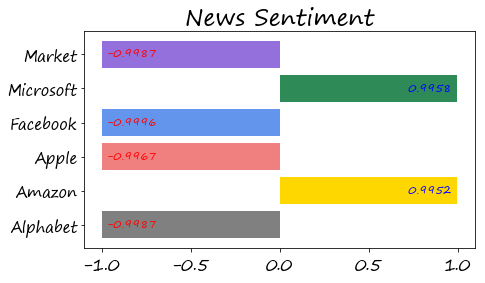

In [92]:
x = list(onem_news['name'])
x_pos = [i for i, _ in enumerate(x)]
plt.figure(figsize=(7,4))
plt.title('News Sentiment')
plt.yticks(x_pos,x,fontsize=15)

y = onem_news['score']
for i, v in enumerate(y):
    if v > 0:
        plt.text(v-0.3, i, " "+str(v), color='blue', va='center',fontsize=11) #fontweight='bold'
    else:
        plt.text(v, i, " "+str(v), color='red', va='center',fontsize=11)

plt.barh(range(len(onem_news['score'])),onem_news['score'],color=['gray','gold','lightcoral','cornflowerblue','seagreen','mediumpurple'])

意料外的分布極端，分數和上面的結果一致。應用上如果把時間縮短為一天或一週，就可以看出公司或市場的評價，進而推測人們對其的信心，甚至是股市的狀況。    

### K-means#1  

列出各字在不同文本中出現的次數

In [165]:
#print(corpus[0:10])
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(stop_words=stop_words)
matrix = vec.fit_transform(corpusk[:1000])
df_cot = pd.DataFrame(matrix.toarray(), columns=vec.get_feature_names())
df_cot.head()

,ab,abandoned,ability,ablaze,able,abolish,absence,abu,abuse,abusing,...,zelenskiy,zetsche,zharov,zhejiang,zombie,zoom,zozo,zte,zuckerberg,zynga
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [166]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(use_idf=False, norm='l1')
matrix = vec.fit_transform(corpusk[:1000])
df_tfid = pd.DataFrame(matrix.toarray(), columns=vec.get_feature_names())
df_tfid.head()

,ab,abandoned,ability,ablaze,able,abolish,absence,abu,abuse,abusing,...,zelenskiy,zetsche,zharov,zhejiang,zombie,zoom,zozo,zte,zuckerberg,zynga
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [167]:
matrix

<1000x4416 sparse matrix of type '<class 'numpy.float64'>'
	with 19335 stored elements in Compressed Sparse Row format>

In [168]:
from sklearn.neighbors import NearestNeighbors

model_tf_idf = NearestNeighbors(metric='cosine', algorithm='brute')
model_tf_idf.fit(matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

可以根據指定字按出現次數列出文本  

In [170]:
df_tfid.sort_values(by='youtube', ascending=False)[0:5]

,ab,abandoned,ability,ablaze,able,abolish,absence,abu,abuse,abusing,...,zelenskiy,zetsche,zharov,zhejiang,zombie,zoom,zozo,zte,zuckerberg,zynga
667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
413,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
580,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


將新聞文字分群，這裡分成5個類別  

In [171]:
# KMeans clustering
from sklearn.cluster import KMeans

number_of_clusters=5
km = KMeans(n_clusters=number_of_clusters)
# Normally people fit the matrix But you could fit the idf_df instead
km.fit(matrix)

km.fit

<bound method KMeans.fit of KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)>

In [172]:
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vec.get_feature_names()
for i in range(number_of_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :5]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

Top terms per cluster:
Cluster 0: technology huawei china network chinese
Cluster 1: chief executive musk tesla elon
Cluster 2: telecom equipment security huawei network
Cluster 3: million service new apple technology
Cluster 4: company technology billion million new


In [173]:
km.labels_

array([4, 4, 3, 2, 3, 3, 3, 0, 3, 3, 4, 3, 0, 4, 3, 3, 3, 3, 0, 4, 3, 4,
       4, 3, 3, 4, 2, 3, 4, 4, 0, 0, 4, 0, 0, 4, 3, 3, 3, 3, 0, 0, 3, 2,
       1, 3, 3, 3, 4, 4, 1, 3, 4, 3, 1, 4, 3, 3, 0, 3, 4, 3, 2, 3, 2, 3,
       0, 3, 3, 3, 3, 1, 3, 3, 3, 4, 3, 3, 4, 3, 3, 4, 3, 1, 3, 1, 4, 3,
       3, 1, 3, 4, 3, 1, 1, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 1, 3, 0, 3,
       4, 1, 3, 3, 3, 0, 3, 3, 0, 3, 0, 3, 0, 0, 4, 3, 4, 0, 4, 4, 4, 4,
       3, 1, 3, 3, 3, 3, 3, 3, 4, 4, 4, 1, 3, 0, 0, 3, 0, 3, 0, 3, 3, 2,
       4, 0, 4, 0, 3, 4, 4, 3, 3, 1, 1, 3, 3, 3, 1, 1, 3, 4, 3, 0, 3, 3,
       4, 3, 1, 3, 4, 3, 4, 0, 4, 0, 0, 2, 0, 4, 3, 3, 4, 3, 4, 3, 0, 3,
       0, 3, 4, 3, 1, 4, 3, 3, 4, 0, 3, 4, 3, 3, 3, 4, 4, 3, 3, 3, 4, 4,
       3, 3, 4, 3, 3, 4, 3, 1, 3, 3, 3, 4, 0, 0, 0, 4, 3, 0, 3, 3, 3, 3,
       3, 4, 3, 4, 3, 3, 4, 3, 4, 3, 3, 0, 1, 4, 3, 3, 3, 3, 2, 3, 4, 3,
       3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 4, 4, 3, 0, 4, 3, 1, 3, 0,
       4, 3, 3, 4, 0, 0, 3, 3, 3, 3, 2, 4, 3, 3, 4,

列出各則新聞被歸類的分群  

In [174]:
results = pd.DataFrame()
results['text'] = corpusk[0:1000]
results['category'] = km.labels_
results.head()

,text,category
0,tesla set raise billion record setting capital...,4
1,uber technology driver new go strike next week...,4
2,trade official rejected tesla bid relief presi...,3
3,global security official agreed set proposal f...,2
4,world need wary rise tech giant google apple f...,3


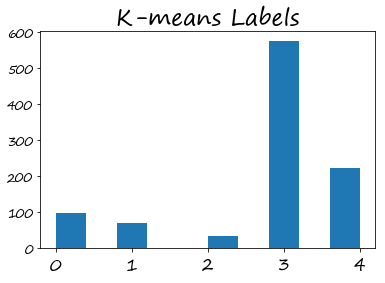

In [175]:
plt.hist(km.labels_, bins=10)
plt.title('K-means Labels')
plt.show()

看起來各群並非平均分布  

如果不確定要在分群時k的取值，可以選一範圍找出各值之下的績效，再作決定  

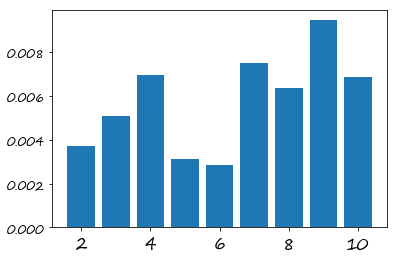

[0.003709820535968676, 0.0051046570147260046, 0.006936207461487541, 0.003106279105584158, 0.0028485055935334926, 0.007484758184177645, 0.006364809055394822, 0.009456372723048747, 0.006862485497201046]


In [176]:
from sklearn import cluster, datasets, metrics

silhouette_avgs = []
ks = range(2, 11)
for k in ks:
    kmeans_fit = KMeans(n_clusters = k).fit(matrix)
    cluster_labels = kmeans_fit.labels_
    silhouette_avg = metrics.silhouette_score(matrix, cluster_labels)
    silhouette_avgs.append(silhouette_avg)

# 作圖並印出 k = 2 到 10 的績效
plt.bar(ks, silhouette_avgs)
plt.show()
print(silhouette_avgs)

分數其實都蠻低的，也許群聚現象並沒有很明顯  

### Word2Vec、K-means

由於上面的結果沒有很明確，且有點不知道如何進一步視覺化，於是不死心用word2vec再分別對句子以及單字做一次clustering  

In [196]:
# training data
sentences = []
for i in corpusk[:100]:
    sentences.append(word_tokenize(i))
print(sentences[:5])

[['tesla', 'set', 'raise', 'billion', 'record', 'setting', 'capital', 'raising', 'electric', 'carmaker', 'investor', 'scooped', 'mix', 'new', 'stock', 'convertible', 'note', 'recharge', 'company', 'cash', 'depleted', 'balance', 'sheet'], ['uber', 'technology', 'driver', 'new', 'go', 'strike', 'next', 'week', 'shortly', 'ride', 'hailing', 'company', 'go', 'public', 'protest', 'view', 'unfair', 'employment', 'condition', 'taxi', 'union'], ['trade', 'official', 'rejected', 'tesla', 'bid', 'relief', 'president', 'donald', 'trump', 'percent', 'tariff', 'chinese', 'made', 'autopilot', 'brain', 'model', 'electric', 'vehicle', 'product', 'denial', 'linked', 'china', 'industrial', 'development', 'plan'], ['global', 'security', 'official', 'agreed', 'set', 'proposal', 'future', 'g', 'network', 'highlighting', 'concern', 'equipment', 'supplied', 'vendor', 'might', 'subject', 'state', 'influence'], ['world', 'need', 'wary', 'rise', 'tech', 'giant', 'google', 'apple', 'facebook', 'amazon', 'compari

In [197]:
from gensim.models import Word2Vec
from nltk.cluster import KMeansClusterer
import numpy as np

model = Word2Vec(sentences, min_count=2) #cut out the word that occured less than 2 times
print(model)

Word2Vec(vocab=370, size=100, alpha=0.025)


In [198]:
def sent_vectorizer(sent, model):
    sent_vec =[]
    numw = 0
    for w in sent:
        try:
            if numw == 0:
                sent_vec = model.wv[w]
            else:
                sent_vec = np.add(sent_vec, model.wv[w])
            numw+=1
        except:
            pass
     
    return np.asarray(sent_vec) / numw

In [199]:
X=[]
for sentence in sentences:
    X.append(sent_vectorizer(sentence, model))   
    
print (X[0])

[ 0.00025367  0.00108755 -0.00067352 -0.00038303 -0.00139485 -0.00079651
 -0.00141705 -0.0009674   0.00122148  0.00039376  0.00036995 -0.00079572
  0.00017409 -0.00099881 -0.00006102 -0.00047867  0.00033538  0.00035523
  0.00165036  0.00105803  0.00126659  0.00222047  0.00145588  0.00093328
  0.00072109 -0.00042887  0.00068    -0.00080783  0.00072822  0.00116729
 -0.00074284 -0.00016019 -0.00005767  0.00044428 -0.00111607  0.00036963
  0.000102   -0.00087068  0.00051955 -0.00011129  0.00053823  0.00057548
  0.00168311  0.00066397  0.00038828 -0.00052056  0.00061113 -0.00032992
  0.00073095  0.00016931 -0.00070396 -0.00069605  0.00053744  0.00021196
 -0.00037269  0.00016217  0.00204622  0.00013039  0.00008666  0.00007703
 -0.00049331 -0.00022879 -0.00012079 -0.00136299  0.00110088 -0.00069195
 -0.00056332 -0.00116712 -0.000985   -0.00013069 -0.00037444  0.00070898
 -0.00060472 -0.00084438  0.00029045 -0.00082597  0.00087086  0.00093454
 -0.00008825  0.0003183   0.00066972 -0.00011247  0

可以計算兩字之間相似度，或設定條件找符合字  

In [200]:
print (model.wv.similarity('raise', 'profit'))
print (model.wv.most_similar(positive=['new'], negative=[], topn=2))

-0.03841735015164006
[('citing', 0.2656247615814209), ('settle', 0.25244447588920593)]


### K-means#2  

分成三個類別  

In [201]:
NUM_CLUSTERS=3
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25) #minus the cosine of the angle between vectors v and u. This is equal to 1 – (u.v / |u||v|)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)

print (assigned_clusters)

[2, 2, 0, 0, 2, 1, 0, 2, 1, 0, 2, 0, 2, 2, 0, 1, 2, 2, 2, 2, 1, 1, 0, 0, 0, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 0, 1, 1, 0, 1, 1, 1, 1, 0, 2, 2, 1, 2, 2, 2, 0, 2, 0, 0, 1, 2, 2, 0, 1, 2, 2, 1, 2, 1, 1, 1, 0, 1, 2, 2, 1, 1, 0, 2, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 2, 0, 1, 0, 2, 1, 0, 1, 0, 1, 2, 0, 1, 1]


輸出詳細結果(個別句子分到的類別、分群演算法的績效(Silhouette係數))  

In [207]:
for index, sentence in enumerate(sentences):    
    print (str(assigned_clusters[index]) + ":" + str(sentence))
    
#for j in range(len(sentences)):
    #print ("%s %s" % (assigned_clusters[j],  sentences[j]))

kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)
kmeans.fit(X)
  
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
  
print ("Cluster id labels for inputted data")
print (labels)
print ("Centroids data")
print (centroids)
  
print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
print (kmeans.score(X))
  
silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')

print ("Silhouette_score: ")
print (silhouette_score)


2:['tesla', 'set', 'raise', 'billion', 'record', 'setting', 'capital', 'raising', 'electric', 'carmaker', 'investor', 'scooped', 'mix', 'new', 'stock', 'convertible', 'note', 'recharge', 'company', 'cash', 'depleted', 'balance', 'sheet']
2:['uber', 'technology', 'driver', 'new', 'go', 'strike', 'next', 'week', 'shortly', 'ride', 'hailing', 'company', 'go', 'public', 'protest', 'view', 'unfair', 'employment', 'condition', 'taxi', 'union']
0:['trade', 'official', 'rejected', 'tesla', 'bid', 'relief', 'president', 'donald', 'trump', 'percent', 'tariff', 'chinese', 'made', 'autopilot', 'brain', 'model', 'electric', 'vehicle', 'product', 'denial', 'linked', 'china', 'industrial', 'development', 'plan']
0:['global', 'security', 'official', 'agreed', 'set', 'proposal', 'future', 'g', 'network', 'highlighting', 'concern', 'equipment', 'supplied', 'vendor', 'might', 'subject', 'state', 'influence']
2:['world', 'need', 'wary', 'rise', 'tech', 'giant', 'google', 'apple', 'facebook', 'amazon', 'co

觀察句子，仍然很難第一眼看就找到分類標準，績效分數一樣接近0  

畫出各類分布圖觀察群聚情況  

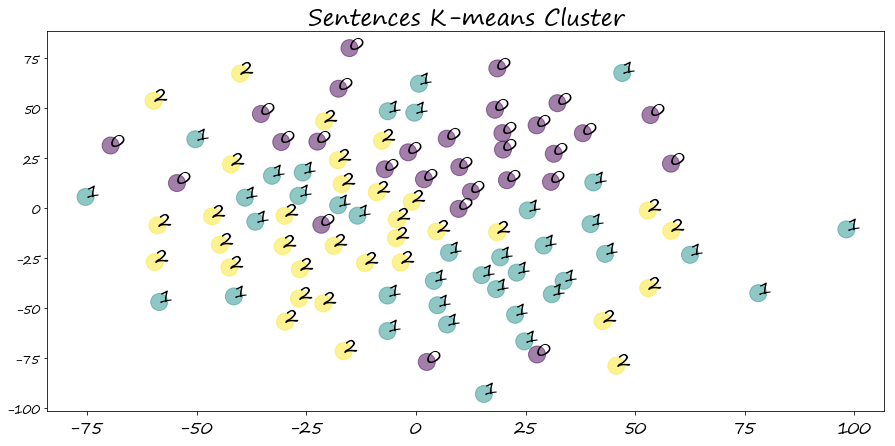

In [203]:
from sklearn.manifold import TSNE
 
modelt = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
 
Y=modelt.fit_transform(X)

plt.figure(figsize=(15,7))
plt.title('Sentences K-means Cluster')
plt.scatter(Y[:, 0], Y[:, 1], c=assigned_clusters, s=290,alpha=.5)

for j in range(len(sentences)):    
    plt.annotate(assigned_clusters[j],xy=(Y[j][0], Y[j][1]),xytext=(0,0),textcoords='offset points')

plt.show()

感覺分群的界線並不明顯，可能是因為科技新聞同質性高，或者是樣本數過少的關係  

### PCA

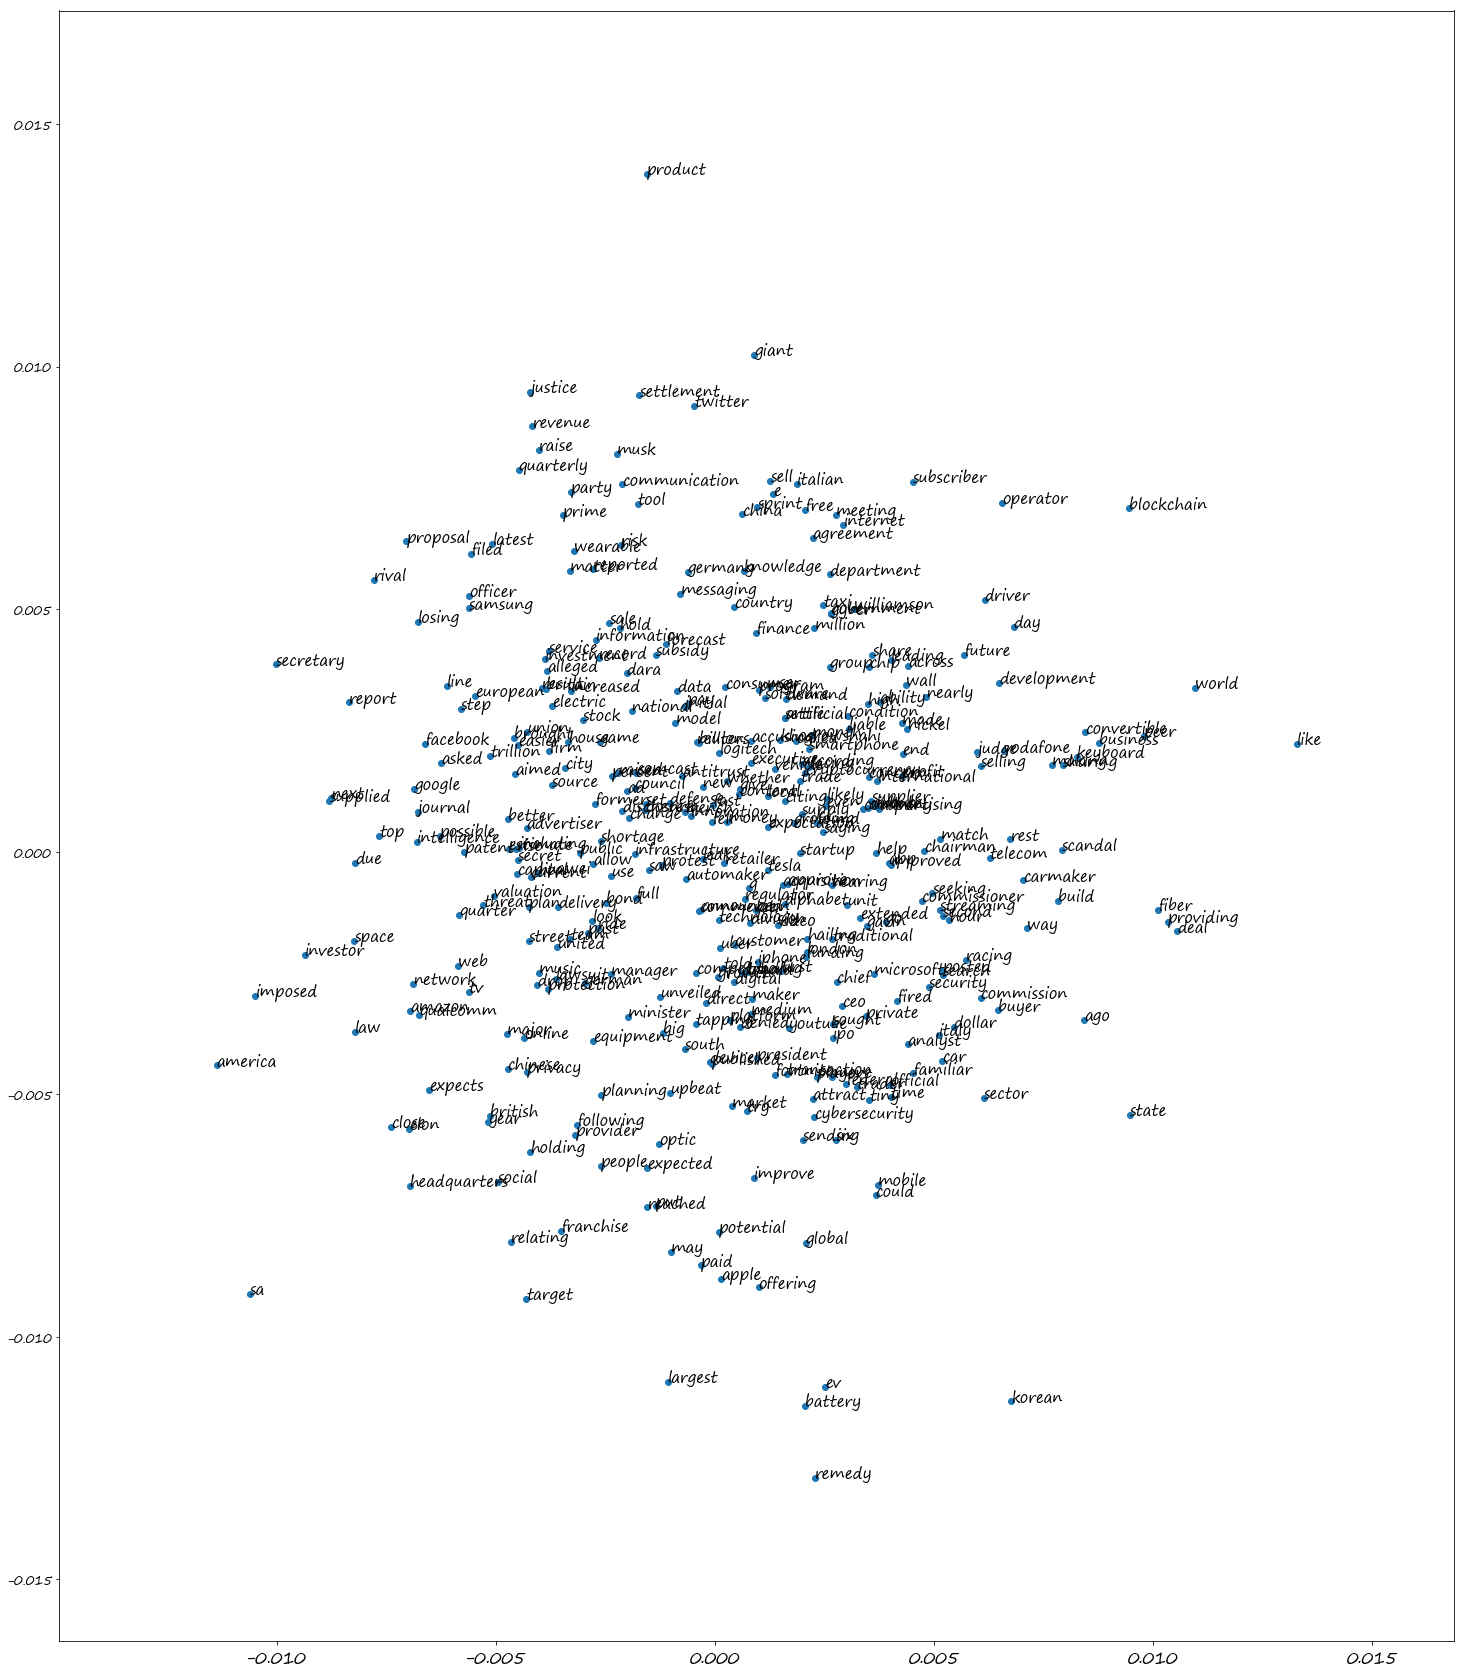

In [208]:
from sklearn.decomposition import PCA

# fit a 2d PCA model to the vectors
X = model.wv[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

plt.figure(figsize=(25,30))
# create a scatter plot of the projection
plt.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)

for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]),size=15)
plt.show()

至此，覺得K-means的結果參考價值相對較低，假定程式過程沒有出錯，則顯然要用別的方法分析新聞文本。  

像以下方式直接找相關程度高的字詞，在選字精準的情況下可能才可以找到特定文字和股價之間的相關因子  

In [212]:
print(model.wv.most_similar(positive=['rise'], negative=[], topn=2))

[('innovation', 0.2599114775657654), ('unit', 0.25033804774284363)]


#### 結論  
* 文字清理的部分的確佔了不少時間，不過如果前面沒有處理好在後面的分析就會一直出錯，因此文字預處理很重要，由於使用科技以及財經相關的文本，停用字或關鍵字也有特別考慮專業術語的部分。  
  
* 從分析結果來看，文字情緒分析目前看來可以納入投資模型當作策略之一，不過數據僅呈現正負向分數，忽略不少細節，且打分機制需要再針對不同字給恰當的分數才能採用。  
  
* 字詞出現頻率的分析，優點是可以經過自己的判斷，得出文字取向。  
  
* 文字群聚分析的部分，可見工具的功能都很強大，基本上資料丟進去都能夠分類，上面的結果沒有找出明顯的類別，但將文字轉成矩陣後對於相關性的判斷很有幫助。  

> 下一步為股價走勢(stock_backtesting.ipynb)和新聞文字比較，找出關聯性，建立相應投資策略模型  